### Data Prep

Loading the token-wise surprisals, aligning them with the word-level RTs, and computing predictors. Length & log frequency are control predictors, and we also add the previous token's surprisal, length, and frequency to control for spill-over effects. Exclude OOV items and items before/after punctuation/non-alphabetical tokens.

In [2]:
import json
import numpy as np
import pandas as pd
from src.tokenization_analysis import *

Align surprisals with RTs, generate predictors for each tokenization scheme for Dundee corpus data

In [3]:
rt_data = "data/processed_rts/dundee_rts.csv"
orth = "data/surprisal_data/dundee/baseline.csv"
bpe = "data/surprisal_data/dundee/bpe.csv"
morph = "data/surprisal_data/dundee/morph_surprisal.csv"

rts = preprocess_rt_data(rt_data)
model_config = json.load(open("model_config.json"))

orth_data = process_surprisal_data(rts, orth, model_config['orth'], 'dundee')
bpe_data = process_surprisal_data(rts, bpe, model_config['bpe'], 'dundee')
morph_data = process_surprisal_data(rts, morph, model_config['transducer'], 'dundee', use_lookup = True)
# different items would be OOV under different tokenization schemes, this makes sure we compare the same dataset

common_index = orth_data.index.intersection(bpe_data.index).intersection(morph_data.index)
dundee_all = combine_corpus_data([orth_data, bpe_data, morph_data], ['orthographic', 'bpe', 'morphological'], common_index)
dundee_all['corpus'] = "dundee"

/Users/sathvik/Desktop/umd/dl-psych-tokenization/src/tokenization_analysis.py:92: FutureWarning: The default value of regex will change from True to False in a future version.
  rts["token"] = rts["token"].str.replace('[^\w\s]','')
/Users/sathvik/Desktop/umd/dl-psych-tokenization/src/tokenization_analysis.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surprisal_rts['tokenization'] = col_name


Showing how many words got split up into different numbers of tokens

In [4]:
labels = ["Tokens Per Word", "Number of Words"]
bpe_dundee_tokens = generate_token_counts(bpe_data['num_tokens'], labels)
bpe_dundee_tokens['Proportion of Corpus'] = bpe_dundee_tokens['Number of Words'] / bpe_dundee_tokens['Number of Words'].sum()
bpe_dundee_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,34273,0.944732
1,2,1521,0.041926
2,3,444,0.012239
3,4,38,0.001047
4,5,2,0.000055


In [5]:
morph_dundee_tokens = generate_token_counts(morph_data['num_tokens'], labels)
morph_dundee_tokens['Proportion of Corpus'] = morph_dundee_tokens['Number of Words'] / morph_dundee_tokens['Number of Words'].sum()
morph_dundee_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,27470,0.757396
1,2,7628,0.210317
2,3,1088,0.029998
3,4,79,0.002178
4,5,4,0.000110


What happens when we exclude stopwords?

In [6]:
from nltk.corpus import stopwords

In [7]:
bpe_without_stopwords = bpe_data[~bpe_data['token'].isin(stopwords.words('english'))]
morph_without_stopwords = morph_data[~morph_data['token'].isin(stopwords.words('english'))]
dundee_bpe_tokens = generate_token_counts(bpe_without_stopwords['num_tokens'], labels)
dundee_bpe_tokens['Proportion of Corpus'] = dundee_bpe_tokens['Number of Words'] / dundee_bpe_tokens['Number of Words'].sum()
dundee_bpe_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,15509,0.885520
1,2,1521,0.086845
2,3,444,0.025351
3,4,38,0.002170
4,5,2,0.000114


In [8]:
dundee_morph_tokens = generate_token_counts(morph_without_stopwords['num_tokens'], labels)
dundee_morph_tokens['Proportion of Corpus'] = dundee_morph_tokens['Number of Words'] / dundee_morph_tokens['Number of Words'].sum()
dundee_morph_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,9621,0.549614
1,2,6719,0.383833
2,3,1082,0.061811
3,4,79,0.004513
4,5,4,0.000229


Running the same steps for the Natural Stories corpus

In [9]:
rt_data = "data/processed_rts/natural_stories_rts.csv"
orth = "data/surprisal_data/natural_stories/orthographical_surprisal.csv"
bpe = "data/surprisal_data/natural_stories/bpe_surprisal.csv"
morph = "data/surprisal_data/natural_stories/morph_surprisal.csv"

rts = preprocess_rt_data(rt_data)
model_config = json.load(open("model_config.json"))

orth_data = process_surprisal_data(rts, orth, model_config['orth'], 'natural_stories', prev_tokens = 3)
bpe_data = process_surprisal_data(rts, bpe, model_config['bpe'], 'natural_stories', prev_tokens = 4)
morph_data = process_surprisal_data(rts, morph, model_config['transducer'], 'natural_stories', prev_tokens = 4, use_lookup = True)

common_index = orth_data.index.intersection(bpe_data.index).intersection(morph_data.index)
ns_all = combine_corpus_data([orth_data, bpe_data, morph_data], ['orthographic', 'bpe', 'morphological'], common_index)
ns_all['corpus'] = "natural_stories"

/Users/sathvik/Desktop/umd/dl-psych-tokenization/src/tokenization_analysis.py:92: FutureWarning: The default value of regex will change from True to False in a future version.
  rts["token"] = rts["token"].str.replace('[^\w\s]','')
/Users/sathvik/Desktop/umd/dl-psych-tokenization/src/tokenization_analysis.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surprisal_rts['tokenization'] = col_name


Showing different numbers of tokens in BPE vs. morphological transducers' splits.

In [10]:
ns_bpe_tokens = generate_token_counts(bpe_data['num_tokens'], labels)
ns_bpe_tokens['Proportion of Corpus'] = ns_bpe_tokens['Number of Words'] / ns_bpe_tokens['Number of Words'].sum()
ns_bpe_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,6075,0.951598
1,2,246,0.038534
2,3,62,0.009712
3,4,1,0.000157


In [11]:
ns_morph_tokens = generate_token_counts(morph_data['num_tokens'], labels)
ns_morph_tokens['Proportion of Corpus'] = ns_morph_tokens['Number of Words'] / ns_morph_tokens['Number of Words'].sum()
ns_morph_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,4911,0.769387
1,2,1333,0.208836
2,3,131,0.020523
3,4,8,0.001253


Excluding stopwords

In [12]:
bpe_without_stopwords = bpe_data[~bpe_data['token'].isin(stopwords.words('english'))]
morph_without_stopwords = morph_data[~morph_data['token'].isin(stopwords.words('english'))]
ns_bpe_tokens = generate_token_counts(bpe_without_stopwords['num_tokens'], labels)
ns_bpe_tokens['Proportion of Corpus'] = ns_bpe_tokens['Number of Words'] / ns_bpe_tokens['Number of Words'].sum()
ns_bpe_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,2764,0.899447
1,2,246,0.080052
2,3,62,0.020176
3,4,1,0.000325


In [13]:
ns_morph_tokens = generate_token_counts(morph_without_stopwords['num_tokens'], labels)
ns_morph_tokens['Proportion of Corpus'] = ns_morph_tokens['Number of Words'] / ns_morph_tokens['Number of Words'].sum()
ns_morph_tokens

,Tokens Per Word,Number of Words,Proportion of Corpus
0,1,1794,0.583984
1,2,1139,0.370768
2,3,131,0.042643
3,4,8,0.002604


Writing the data from both corpora to a CSV to run regression models in R

In [14]:
combined_surprisal_rts = pd.concat([dundee_all, ns_all])

combined_surprisal_rts.to_csv("data/surprisal_data/combined_surprisal_rts.csv", index = False)

Writing the stopword info into the CSV as well

In [16]:
df = pd.read_csv("data/surprisal_data/combined_surprisal_rts.csv")
df['is_stopword'] = df['token'].isin(stopwords.words("english"))
df.to_csv("data/surprisal_data/combined_surprisal_rts.csv", index = False)

## Surprisal by Number of Splits

In [15]:
import seaborn as sns
sns.set_style("darkgrid")

Figure 2:

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is 

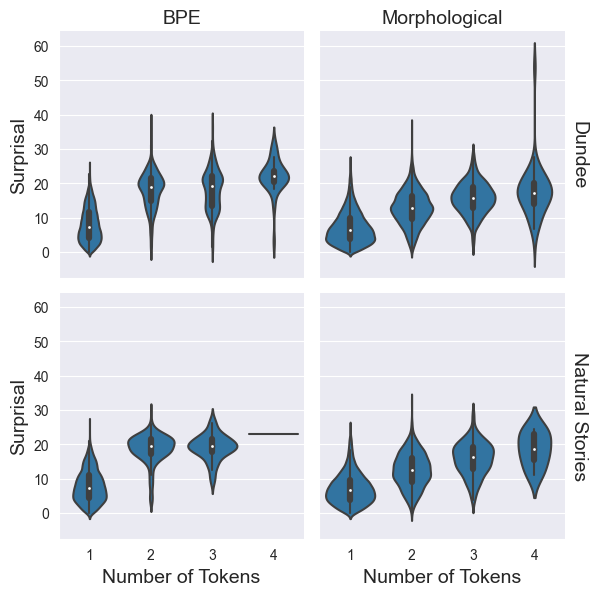

In [20]:
non_orthographic = combined_surprisal_rts[combined_surprisal_rts['tokenization'] != 'orthographic']
def format_segmentation(col_value):
    if col_value == "bpe":
        return "BPE"
    return col_value.capitalize()
def format_corpus(col_value):
    if col_value == "dundee":
        return "Dundee"
    else:
        return "Natural Stories"
non_orthographic['tokenization'] = non_orthographic['tokenization'].apply(lambda name: format_segmentation(name))
non_orthographic['corpus'] = non_orthographic['corpus'].apply(lambda name: format_corpus(name))
g = sns.FacetGrid(non_orthographic, col="tokenization",  row="corpus", margin_titles = True)
g.map(sns.violinplot, "num_tokens", "surprisal")
g.fig.tight_layout()
g.set_xlabels("Number of Tokens", fontsize = 14)
g.set_ylabels("Surprisal", fontsize = 14)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size = 14)


/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


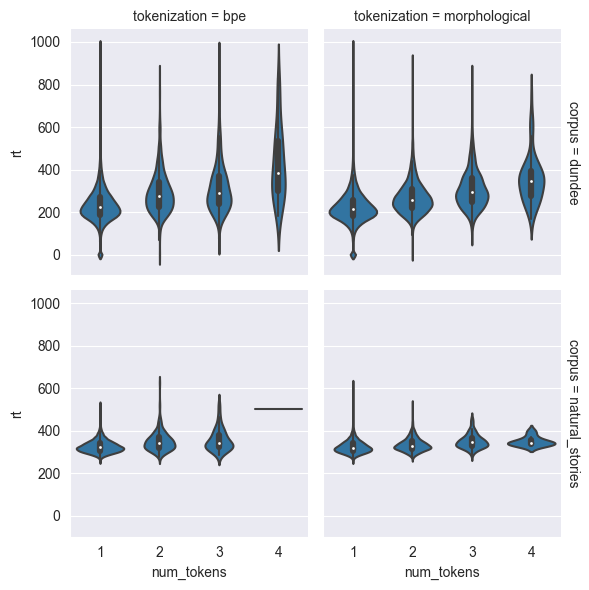

In [20]:
g = sns.FacetGrid(non_orthographic, col="tokenization",  row="corpus", margin_titles = True)
g.map(sns.violinplot, "num_tokens", "rt")


In [30]:
non_orthographic.groupby(["num_tokens", "corpus", "tokenization"])[["surprisal", "rt"]].corr()

surprisal        rt
num_tokens corpus          tokenization                                
1          dundee          bpe           surprisal   1.000000  0.370113
                                         rt          0.370113  1.000000
                           morphological surprisal   1.000000  0.311076
                                         rt          0.311076  1.000000
           natural_stories bpe           surprisal   1.000000  0.246586
                                         rt          0.246586  1.000000
                           morphological surprisal   1.000000  0.212485
                                         rt          0.212485  1.000000
2          dundee          bpe           surprisal   1.000000  0.320399
                                         rt          0.320399  1.000000
                           morphological surprisal   1.000000  0.328575
                                         rt          0.328575  1.000000
           natural_stories bpe           surprisal   1.000000  0.046456
                                         rt          0.046456  1.000000
                           morphological surprisal   1.000000  0.282964
                                         rt          0.282964  1.000000
3          dundee          bpe           surprisal   1.000000  0.403495
                                         rt          0.403495  1.000000
                           morphological surprisal   1.000000  0.270872
                                         rt          0.270872  1.000000
           natural_stories bpe           surprisal   1.000000  0.048858
                                         rt          0.048858  1.000000
                           morphological surprisal   1.000000  0.378162
                                         rt          0.378162  1.000000
4          dundee          bpe           surprisal   1.000000  0.208387
                                         rt          0.208387  1.000000
                           morphological surprisal   1.000000  0.293542
                                         rt          0.293542  1.000000
           natural_stories bpe           surprisal        NaN       NaN
                                         rt               NaN       NaN
                           morphological surprisal   1.000000 -0.055083
                                         rt         -0.055083  1.000000
5          dundee          bpe           surprisal   1.000000  1.000000
                                         rt          1.000000  1.000000
                           morphological surprisal   1.000000  0.863707
                                         rt          0.863707  1.000000

Text(0.5, 1.0, 'Surprisal of Words in Dundee Corpus by Number of BPE Splits')

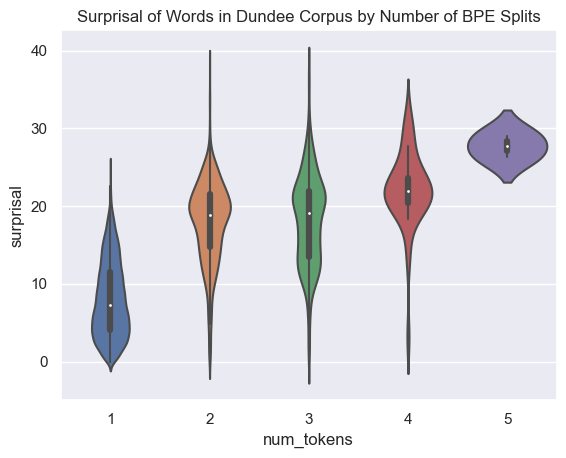

In [22]:
bpe_surprisal = combined_surprisal_rts[(combined_surprisal_rts['tokenization'] == 'bpe') & (combined_surprisal_rts['corpus'] == 'dundee')]
sns.violinplot(x = 'num_tokens', y = 'surprisal', data = bpe_surprisal)
plt.title("Surprisal of Words in Dundee Corpus by Number of BPE Splits")

Text(0.5, 1.0, 'Surprisal of Words in Dundee Corpus by Number of Morphemes')

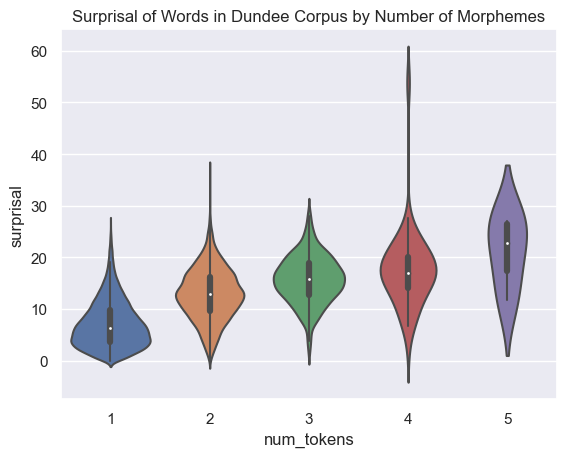

In [24]:
morph_surprisal = combined_surprisal_rts[(combined_surprisal_rts['tokenization'] == 'morphological') & (combined_surprisal_rts['corpus'] == 'dundee')]
sns.violinplot(x = 'num_tokens', y = 'surprisal', data = morph_surprisal)
plt.title("Surprisal of Words in Dundee Corpus by Number of Morphemes")

Text(0.5, 1.0, 'Surprisal of Words in Natural Stories Corpus by Number of BPE Splits')

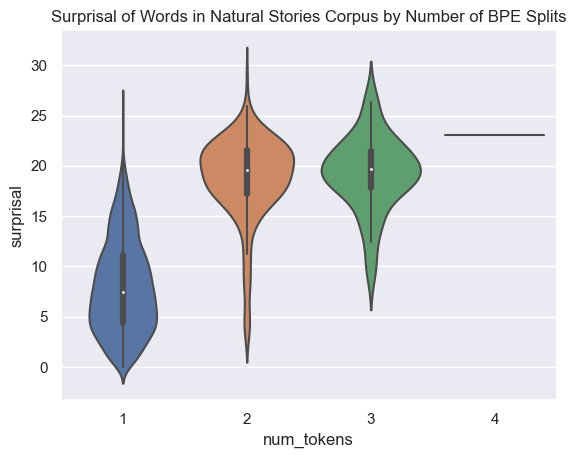

In [25]:
bpe_surprisal = combined_surprisal_rts[(combined_surprisal_rts['tokenization'] == 'bpe') & (combined_surprisal_rts['corpus'] == 'natural_stories')]
sns.violinplot(x = 'num_tokens', y = 'surprisal', data = bpe_surprisal)
plt.title("Surprisal of Words in Natural Stories Corpus by Number of BPE Splits")

Text(0.5, 1.0, 'Surprisal of Words in Natural Stories Corpus by Number of Morphemes')

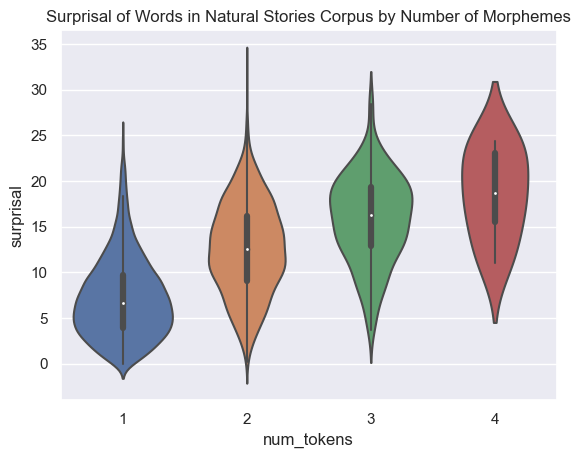

In [26]:
bpe_surprisal = combined_surprisal_rts[(combined_surprisal_rts['tokenization'] == 'morphological') & (combined_surprisal_rts['corpus'] == 'natural_stories')]
sns.violinplot(x = 'num_tokens', y = 'surprisal', data = bpe_surprisal)
plt.title("Surprisal of Words in Natural Stories Corpus by Number of Morphemes")

## Analyzing Large Differences between Morphological and BPE-based Surprisal

We look for words where the morphological tokenization-based LM had a much lower surprisal than the BPE-based one.

In [25]:
data = combined_surprisal_rts[['token', 'surprisal', 'transcript_id', 'sentence_id', 'corpus', 'tokenization']]
bpe_data = data[data['tokenization'] == 'bpe']
morph_data = data[data['tokenization'] == 'morphological']
morph_data['surprisal_diff'] = morph_data['surprisal'] - bpe_data['surprisal']
sorted_morph = morph_data.sort_values('surprisal_diff')

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Looking for examples in the Natural Stories corpus, *bulbs* is the multi-morphemic word with the biggest difference in surprisal.

In [26]:
sorted_morph[sorted_morph['corpus'] == 'natural_stories'].head()

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
3064,late,6.479430,1,147,natural_stories,morphological,-9.824081
8427,bulbs,7.834730,1,411,natural_stories,morphological,-9.469359
9433,condition,5.591241,1,457,natural_stories,morphological,-9.368578
8000,nineteen,10.876982,1,397,natural_stories,morphological,-8.341291
5874,hard,7.184825,1,292,natural_stories,morphological,-8.097639


The sentence has *tulip bulbs*, so it is possible the BPE-based tokenizer may not have picked up on this frequently occurring bigram.

In [27]:
def show_sentence(df, sent_id, transcript_id, corpus_name):
    sentence_tokens = df[(df['sentence_id'] == sent_id) & (df['transcript_id'] == transcript_id) & (df['corpus'] == corpus_name)]['token']
    return ' '.join(sentence_tokens)

In [28]:
sent = show_sentence(morph_data, 411, 1, "natural_stories")
sent

'planted his collection of tulip bulbs that sent to him were able to tolerate the harsher conditions of the'

We now compare how this sentence looks under different tokenization schemes and visualize the results.

In [29]:
tulips = morph_data[morph_data['sentence_id'] == 411].reset_index()
tulips[tulips['token'] == 'bulbs'].index

Int64Index([5], dtype='int64')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.morph_segmenter import load_model_and_vocab, tokenize_sentence
from transformers import AutoTokenizer

sns.set_theme(style = 'darkgrid')

def visualize_morph_bpe_surprisal_diff(bpe, morph, sent_id, transcript_id, corpus_name, word):
    # show how the sentence is tokenized

    bpe_tokenizer = AutoTokenizer.from_pretrained('gpt2')
    transducer, transducer_vocab = load_model_and_vocab("sigmorphon_model/model/")
    print(sent + "\n" + "BPE:")
    bpe_sent = " ".join(bpe_tokenizer.tokenize(sent))
    print(bpe_sent + "\n" + "Morphological: ")
    morph_sent = " ".join(tokenize_sentence(transducer, transducer_vocab, sent, "↓")[0])
    print(morph_sent)
    
    word_morph = extract_one_sentence(morph, sent_id, corpus_name, transcript_id)
    word_bpe = extract_one_sentence(bpe, sent_id, corpus_name, transcript_id)
    
    # in case we get a really long sentence, the most we want to focus on is the five words before & after the target word
    ngram_order = 5
    word_morph = word_morph.reset_index()
    word_bpe = word_bpe.reset_index()
    word_index = word_morph[word_morph['token'] == word].index.values[0]
    start = max(0, word_index - ngram_order)
    end = min(len(word_morph.index), word_index + ngram_order)
    word_morph, word_bpe = word_morph.iloc[start:end], word_bpe.iloc[start:end]
    
    # plotting
    ind = np.arange(end - start)
    palette = sns.color_palette("Dark2")
    width = 0.35
    fig, ax = plt.subplots(figsize = (18, 8))
    ax.bar(ind, word_morph['surprisal'], width, label = "Segmented Morphemes", color = palette[0])
    ax.bar(ind + width, word_bpe['surprisal'], width, label = "BPE", color = palette[2])
    ax.set_xticks(ind)
    ax.set_xticklabels(word_morph['token'].values, fontsize = 24)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylabel("Surprisal", fontsize = 20)
    plt.legend(fontsize = 18)
    plt.show()

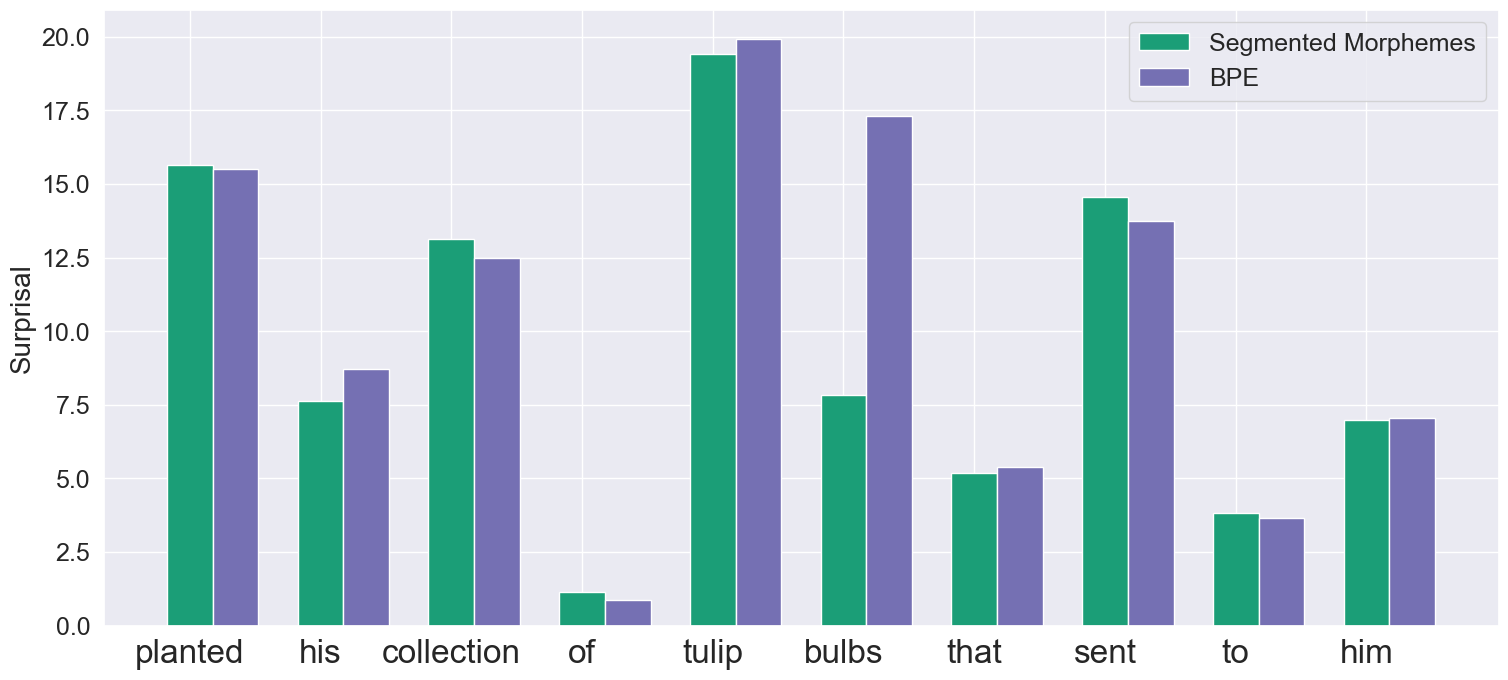

In [64]:
visualize_morph_bpe_surprisal_diff(bpe_data, morph_data, 411, 1, "natural_stories", "bulbs")

Repeating our analysis for words in the Dundee corpus

In [59]:
sorted_morph[sorted_morph['corpus'] == 'dundee'].head()

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
41526,gagarin,22.696480,7,16,dundee,morphological,-14.953188
2613,embryology,19.352882,3,0,dundee,morphological,-14.573388
46420,embryology,19.370683,6,8,dundee,morphological,-14.555586
46339,embryology,19.370683,6,5,dundee,morphological,-14.555586
29605,saeed,9.179002,14,64,dundee,morphological,-14.035922


The morphological transducer treates *embryology* as a whole word and *gagarin* and *saeed* are proper names. This difference may have to do with how the tokens are split up. Instead, we pick *carefully* (34th most negative morphological vs. BPE surprisal difference in the Dundee corpus). It consists of multiple segments instead of a single word with a prefix or suffix.

In [60]:
sorted_morph[sorted_morph['corpus'] == 'dundee'][30:40]

,token,surprisal,transcript_id,sentence_id,corpus,tokenization,surprisal_diff
27656,stable,9.004187,8,85,dundee,morphological,-7.831474
32168,stakeholder,15.600091,4,52,dundee,morphological,-7.760412
20334,richard,8.488529,1,112,dundee,morphological,-7.729669
19074,carefully,7.869497,1,51,dundee,morphological,-7.720871
45348,effect,6.348611,20,76,dundee,morphological,-7.711471
26812,associate,8.132791,8,41,dundee,morphological,-7.710861
40610,speaker,7.985207,17,99,dundee,morphological,-7.702006
21414,reasonable,3.114220,11,41,dundee,morphological,-7.554686
20369,richard,8.488529,1,113,dundee,morphological,-7.489741
39902,see,6.570640,17,60,dundee,morphological,-7.476445


In [61]:
sent = show_sentence(morph_data, 51, 1, 'dundee')
sent

'lies in treading carefully wherever we'

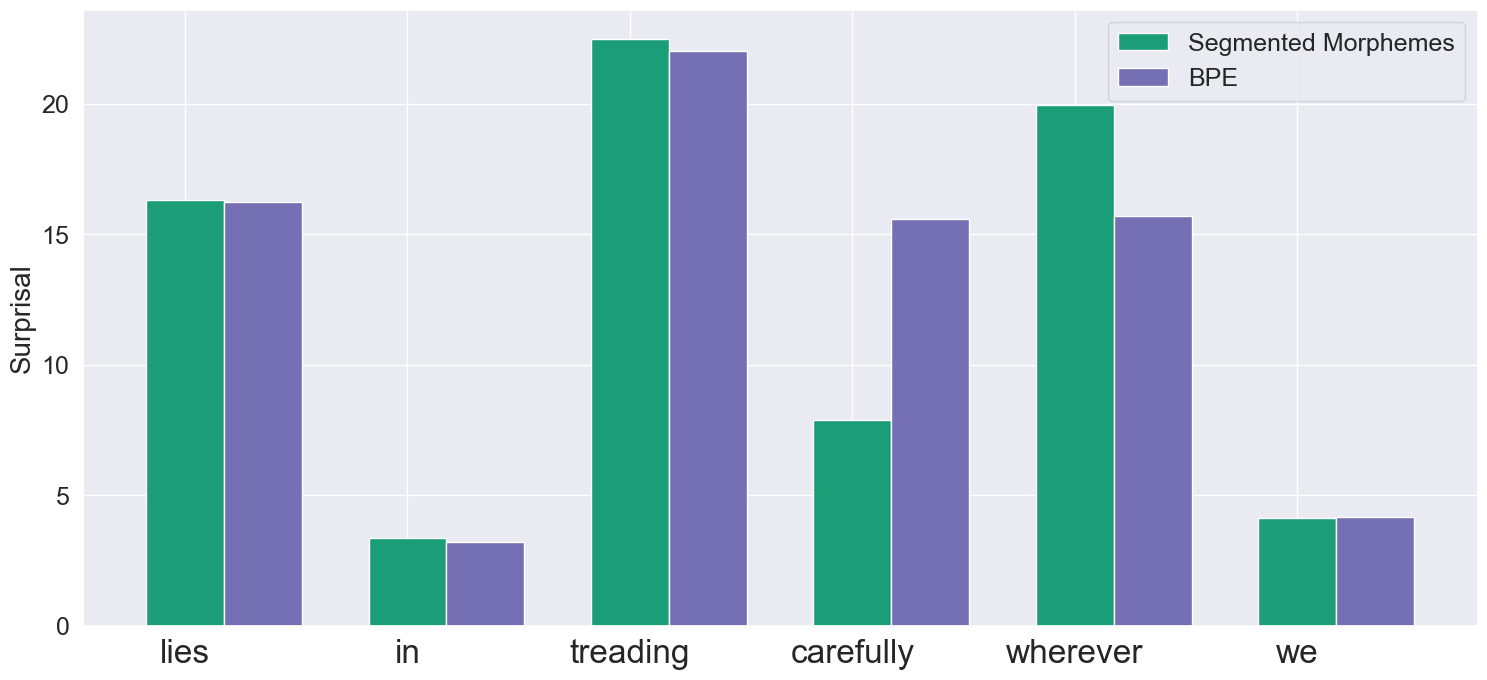

In [65]:
visualize_morph_bpe_surprisal_diff(bpe_data, morph_data, 51, 1, "dundee", "carefully")

### Exploring differences in surprisal distributions

(-5.0, 35.0)

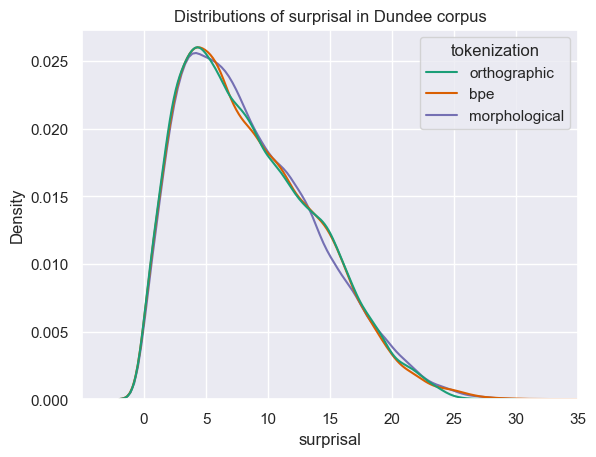

In [20]:
sns.kdeplot(x = 'surprisal', hue = 'tokenization', data = dundee_all, palette = "Dark2")
plt.title("Distributions of surprisal in Dundee corpus")
plt.xticks(np.arange(0, 36, 5))
plt.xlim(-5, 35)

(-5.0, 35.0)

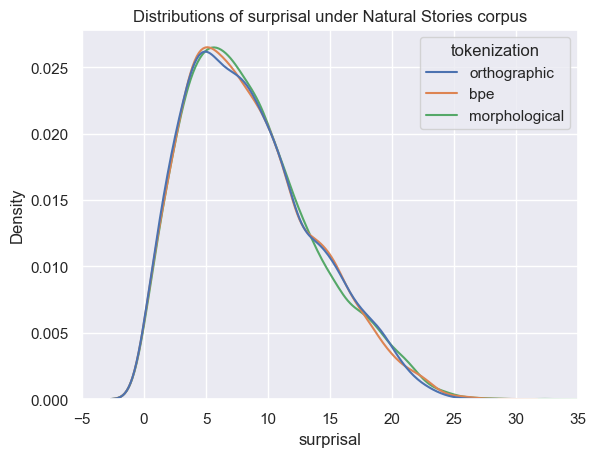

In [22]:
sns.kdeplot(x = 'surprisal', hue = 'tokenization', data = ns_all)
plt.title("Distributions of surprisal under Natural Stories corpus")
plt.xlim(-5, 35)

In [20]:
def perplexity(surprisals):
    return 2 ** np.mean(surprisals)

In [22]:
dundee_all[['tokenization', 'surprisal']].groupby("tokenization").agg(perplexity)

,surprisal
tokenization,
bpe,379.519229
morphological,388.430178
orthographic,367.626249


In [23]:
ns_all[['tokenization', 'surprisal']].groupby("tokenization").agg(perplexity)

,surprisal
tokenization,
bpe,364.930225
morphological,371.293474
orthographic,357.263703
